# Grid Cells

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from grid_cells import GridCells, GridCellModule
from utils import gaussian_grid, device
from tqdm import tqdm


def dist(w, probs, place):
    return np.sum((probs.T @ w - place)**2 * (place + 0.1))

In [2]:
grid_cells = GridCells(np.linspace(100, 200, 5, dtype=int), n_per_module=25,
                       heterogeneous=True, modular_peaks=True, individual=True)
grid_cells.reset_modules(1)
grid_cells.compile_numpy()

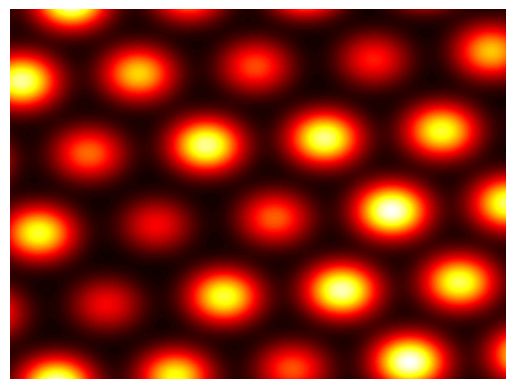

In [3]:
plt.contourf(grid_cells[-1], levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [4]:
lin = np.linspace(-1, 1, 400)
coords = np.stack(np.meshgrid(lin, lin)).transpose(1, 2, 0)

mvn = multivariate_normal(mean=[-.5, -.5], cov=np.eye(2) * 0.01)
place = gaussian_grid(coords, [mvn])
place /= place.max()

In [5]:
p = torch.tensor(grid_cells.grid_cells, dtype=torch.float32, device=device).permute(1, 2, 0)
w = torch.randn(grid_cells.shape[0], requires_grad=True, device=device)
pl = torch.tensor(place, dtype=torch.float32, device=device)
lr = 1e-6

for _ in tqdm(range(20000)):
    loss = torch.sum((p @ w - pl)**2 * (pl + 0.1))
    loss.backward(inputs=[w])
    w = w - lr * w.grad

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:38<00:00, 517.92it/s]


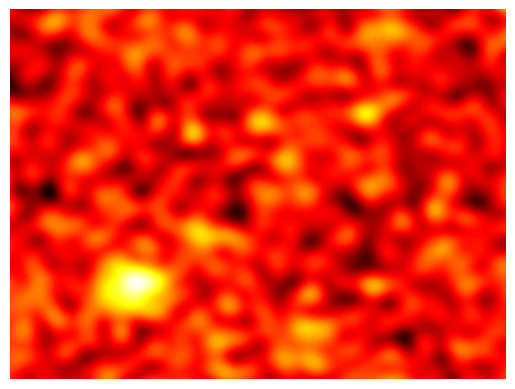

In [6]:
plt.contourf((p @ w).detach().cpu(), levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [ ]:
grid_cells.reset_modules(2)
grid_cells.compile_numpy()

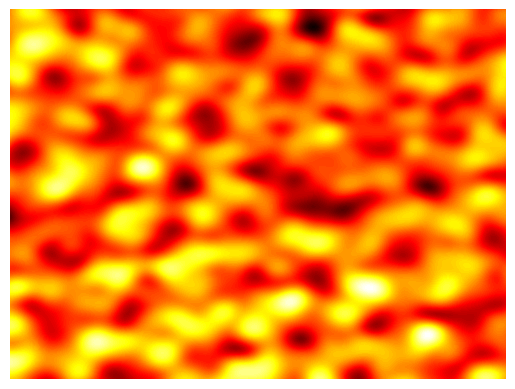

In [ ]:
p = torch.tensor(grid_cells.grid_cells, dtype=torch.float32, device=device).permute(1, 2, 0)
plt.contourf((p @ w).detach().cpu(), levels=100, cmap='hot')
plt.axis('off')
plt.show()

# Thesis figures

In [9]:
from matplotlib.patches import Arc, Rectangle
from skimage.draw import line_aa
from scipy.ndimage import rotate, shift

In [10]:
grid_cells = GridCells(np.linspace(140, 400, 5, dtype=int), n_per_module=4)
grid_cells.reset_modules(1)
grid_cells.compile_numpy()

In [11]:
gcm = grid_cells.modules[3]

In [12]:
lines = gcm.lines_at_60()
lines = [gcm.zeros_with_line(*line_aa(*l)) for l in lines]

image = np.sum(lines, axis=0) > 1
image = gcm.clean_image(image).astype(float)

idx = np.arange(image.shape[0])
idx = np.stack(np.meshgrid(idx, idx))

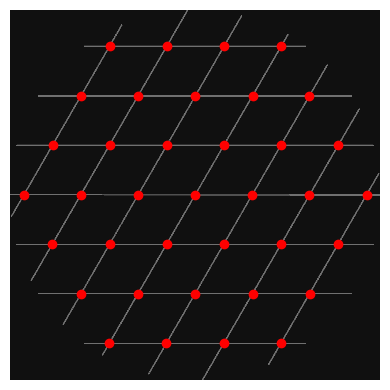

In [13]:
plt.figure(figsize=(4, 4))
plt.contourf(np.sum(lines, axis=0), cmap='gray')
plt.plot(*idx[:,image.astype(bool)], 'ro')
plt.axis('off')
plt.tight_layout()
plt.savefig('figs/gc1.png')
plt.show()

In [14]:
conv = gcm.convolve(image, gcm.get_gaussian_kernel())
res = conv.shape[0]
crop = 600

In [15]:
p = np.linspace(0, gcm.period, 5)
phases = np.stack(np.meshgrid(p, p)).reshape(2, -1).T
shear = gcm.shear2d(np.pi / 6).T
rot = gcm.rot2d(-85 / 180 * np.pi).T
phases = phases @ shear @ rot

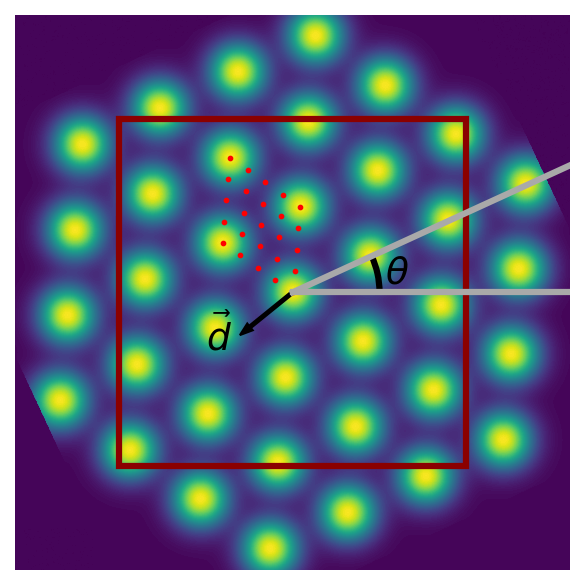

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

# ax.contourf(conv, levels=50)
ax.contourf(shift(rotate(conv, -25, reshape=False), phases[0]), levels=100)
ax.axhline(res / 2, xmin=0.5, linewidth=3, c='darkgray')
ax.plot([res / 2, res - 1], [res / 2, 700], linewidth=3, c='darkgray')
ax.add_patch(Arc((res / 2, res / 2), 300, 300, angle=0, theta1=0, theta2=25, linewidth=3))
ax.text(res / 2 + 160, res / 2 + 15, "$\\theta$", fontsize=18, weight='semibold', c='black')
ax.add_patch(Rectangle(((res - crop) / 2, (res - crop) / 2), crop, crop, linewidth=3, fill=False, color='darkred'))
plt.scatter(*(phases + res / 2).T[::-1], c='r', s=3)
plt.arrow(res / 2, res / 2, -74, -60, width=5, color='black')
ax.text(res / 2 - 150, res / 2 - 100, "$\\vec{d}$", fontsize=18, weight='bold', c='black')
ax.axis('off')
plt.tight_layout()
plt.savefig('figs/gc2.png')
plt.show()

In [17]:
gc = grid_cells[-2]
grid_cells.heterogeneous = True
grid_cells.reset_modules(1)
grid_cells.compile_numpy()

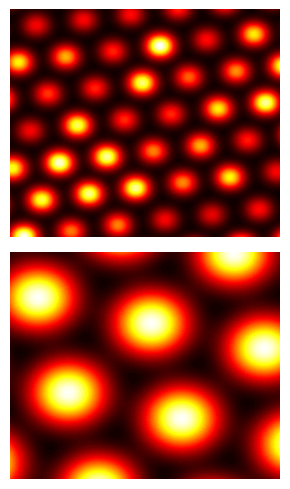

In [18]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 5))
ax1.contourf(grid_cells[2], levels=100, cmap='hot')
ax1.axis('off')
ax2.contourf(gc, levels=100, cmap='hot')
ax2.axis('off')
plt.tight_layout()
plt.savefig('figs/gc3.png')
plt.show()